In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:10<00:00, 19.3MB/s]
100% 149M/149M [00:10<00:00, 15.4MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-tumor-mri-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [5]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Training',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/Testing',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [6]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy

# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [7]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [8]:
# Function for inporting data
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)

        # Avoid MacOS storing path
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)

    return data_path, data_labels

In [9]:
# Setting up file paths for training and testing
USER_PATH = r"//content"
train_dir = USER_PATH + r'/Training/'
test_dir = USER_PATH + r'/Testing/'

# Getting data using above function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


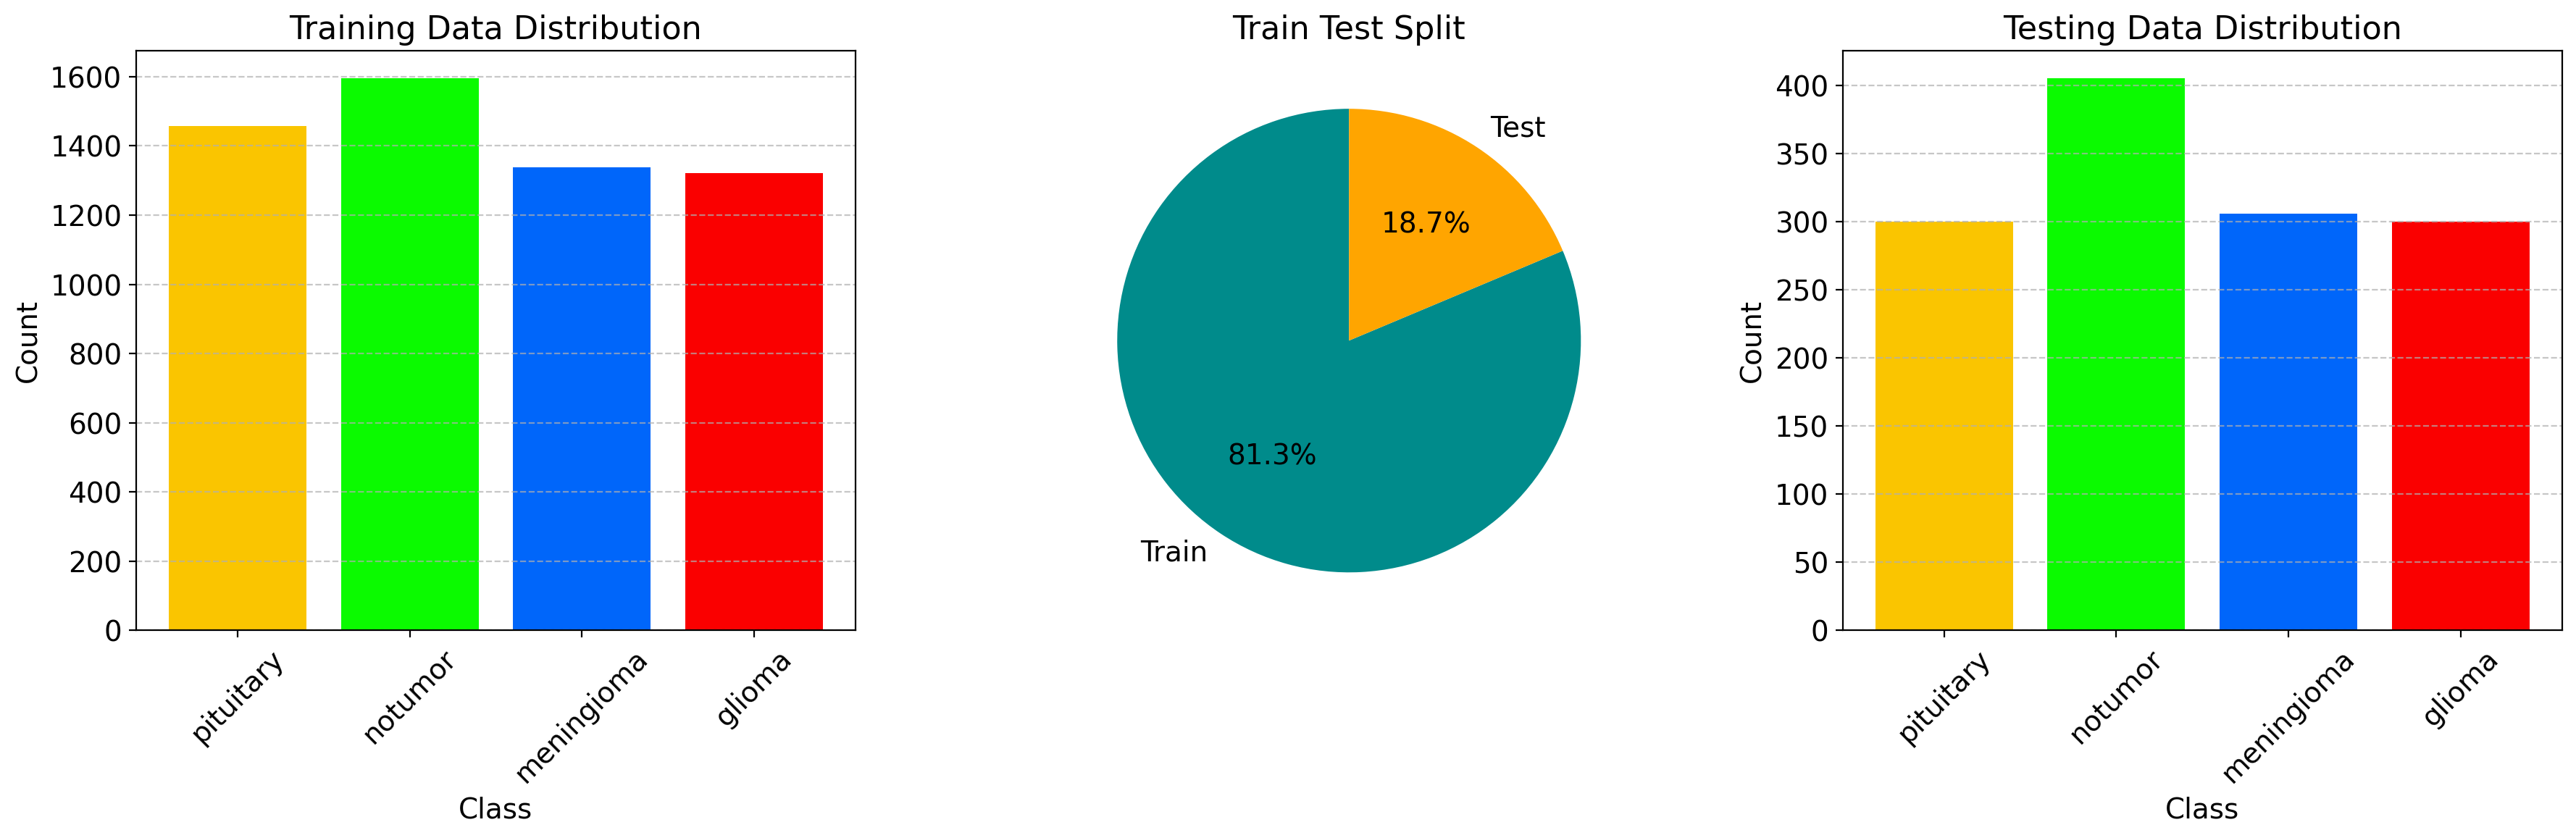

In [44]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting training data distribution
class_counts_train = [len([x for x in train_labels if x == label]) for label in CLASS_TYPES]
axs[0].bar(CLASS_TYPES, class_counts_train, color=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'])
axs[0].set_title('Training Data Distribution', fontsize=16)
axs[0].set_xlabel('Class', fontsize=14)
axs[0].set_ylabel('Count', fontsize=14)
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plotting distribution of train test split
train_percentage = len(train_labels) / (len(train_labels) + len(test_labels)) * 100
test_percentage = len(test_labels) / (len(train_labels) + len(test_labels)) * 100
axs[1].set_title('Train Test Split', fontsize=16)
axs[1].pie(
    [train_percentage, test_percentage],
    labels=['Train', 'Test'],
    colors=['darkcyan', 'orange'],
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 14}
)

# Plotting testing data distribution
class_counts_test = [len([x for x in test_labels if x == label]) for label in CLASS_TYPES]
axs[2].bar(CLASS_TYPES, class_counts_test, color=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'])
axs[2].set_title('Testing Data Distribution', fontsize=16)
axs[2].set_xlabel('Class', fontsize=14)
axs[2].set_ylabel('Count', fontsize=14)
axs[2].tick_params(axis='x', labelrotation=45)
axs[2].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()


x reshaped: (1, 150, 150, 3)


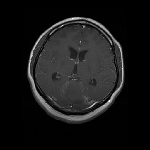

In [11]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [12]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, index_list=range(10), im_size=250, figsize=(12, 8), save=False):
    """
    Show images from a given path based on the inputted
    list indices related to the desired images one wishes
    to see.
    """

    num_images = len(index_list)
    num_rows = (num_images + 3) // 4

    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()

    for i, index in enumerate(index_list):
        if i >= num_images:
            break

        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image)
        ax[i].set_title(f'{index}: {label_paths[index]}')
        ax[i].axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_image.pdf')
    else:
        plt.show()

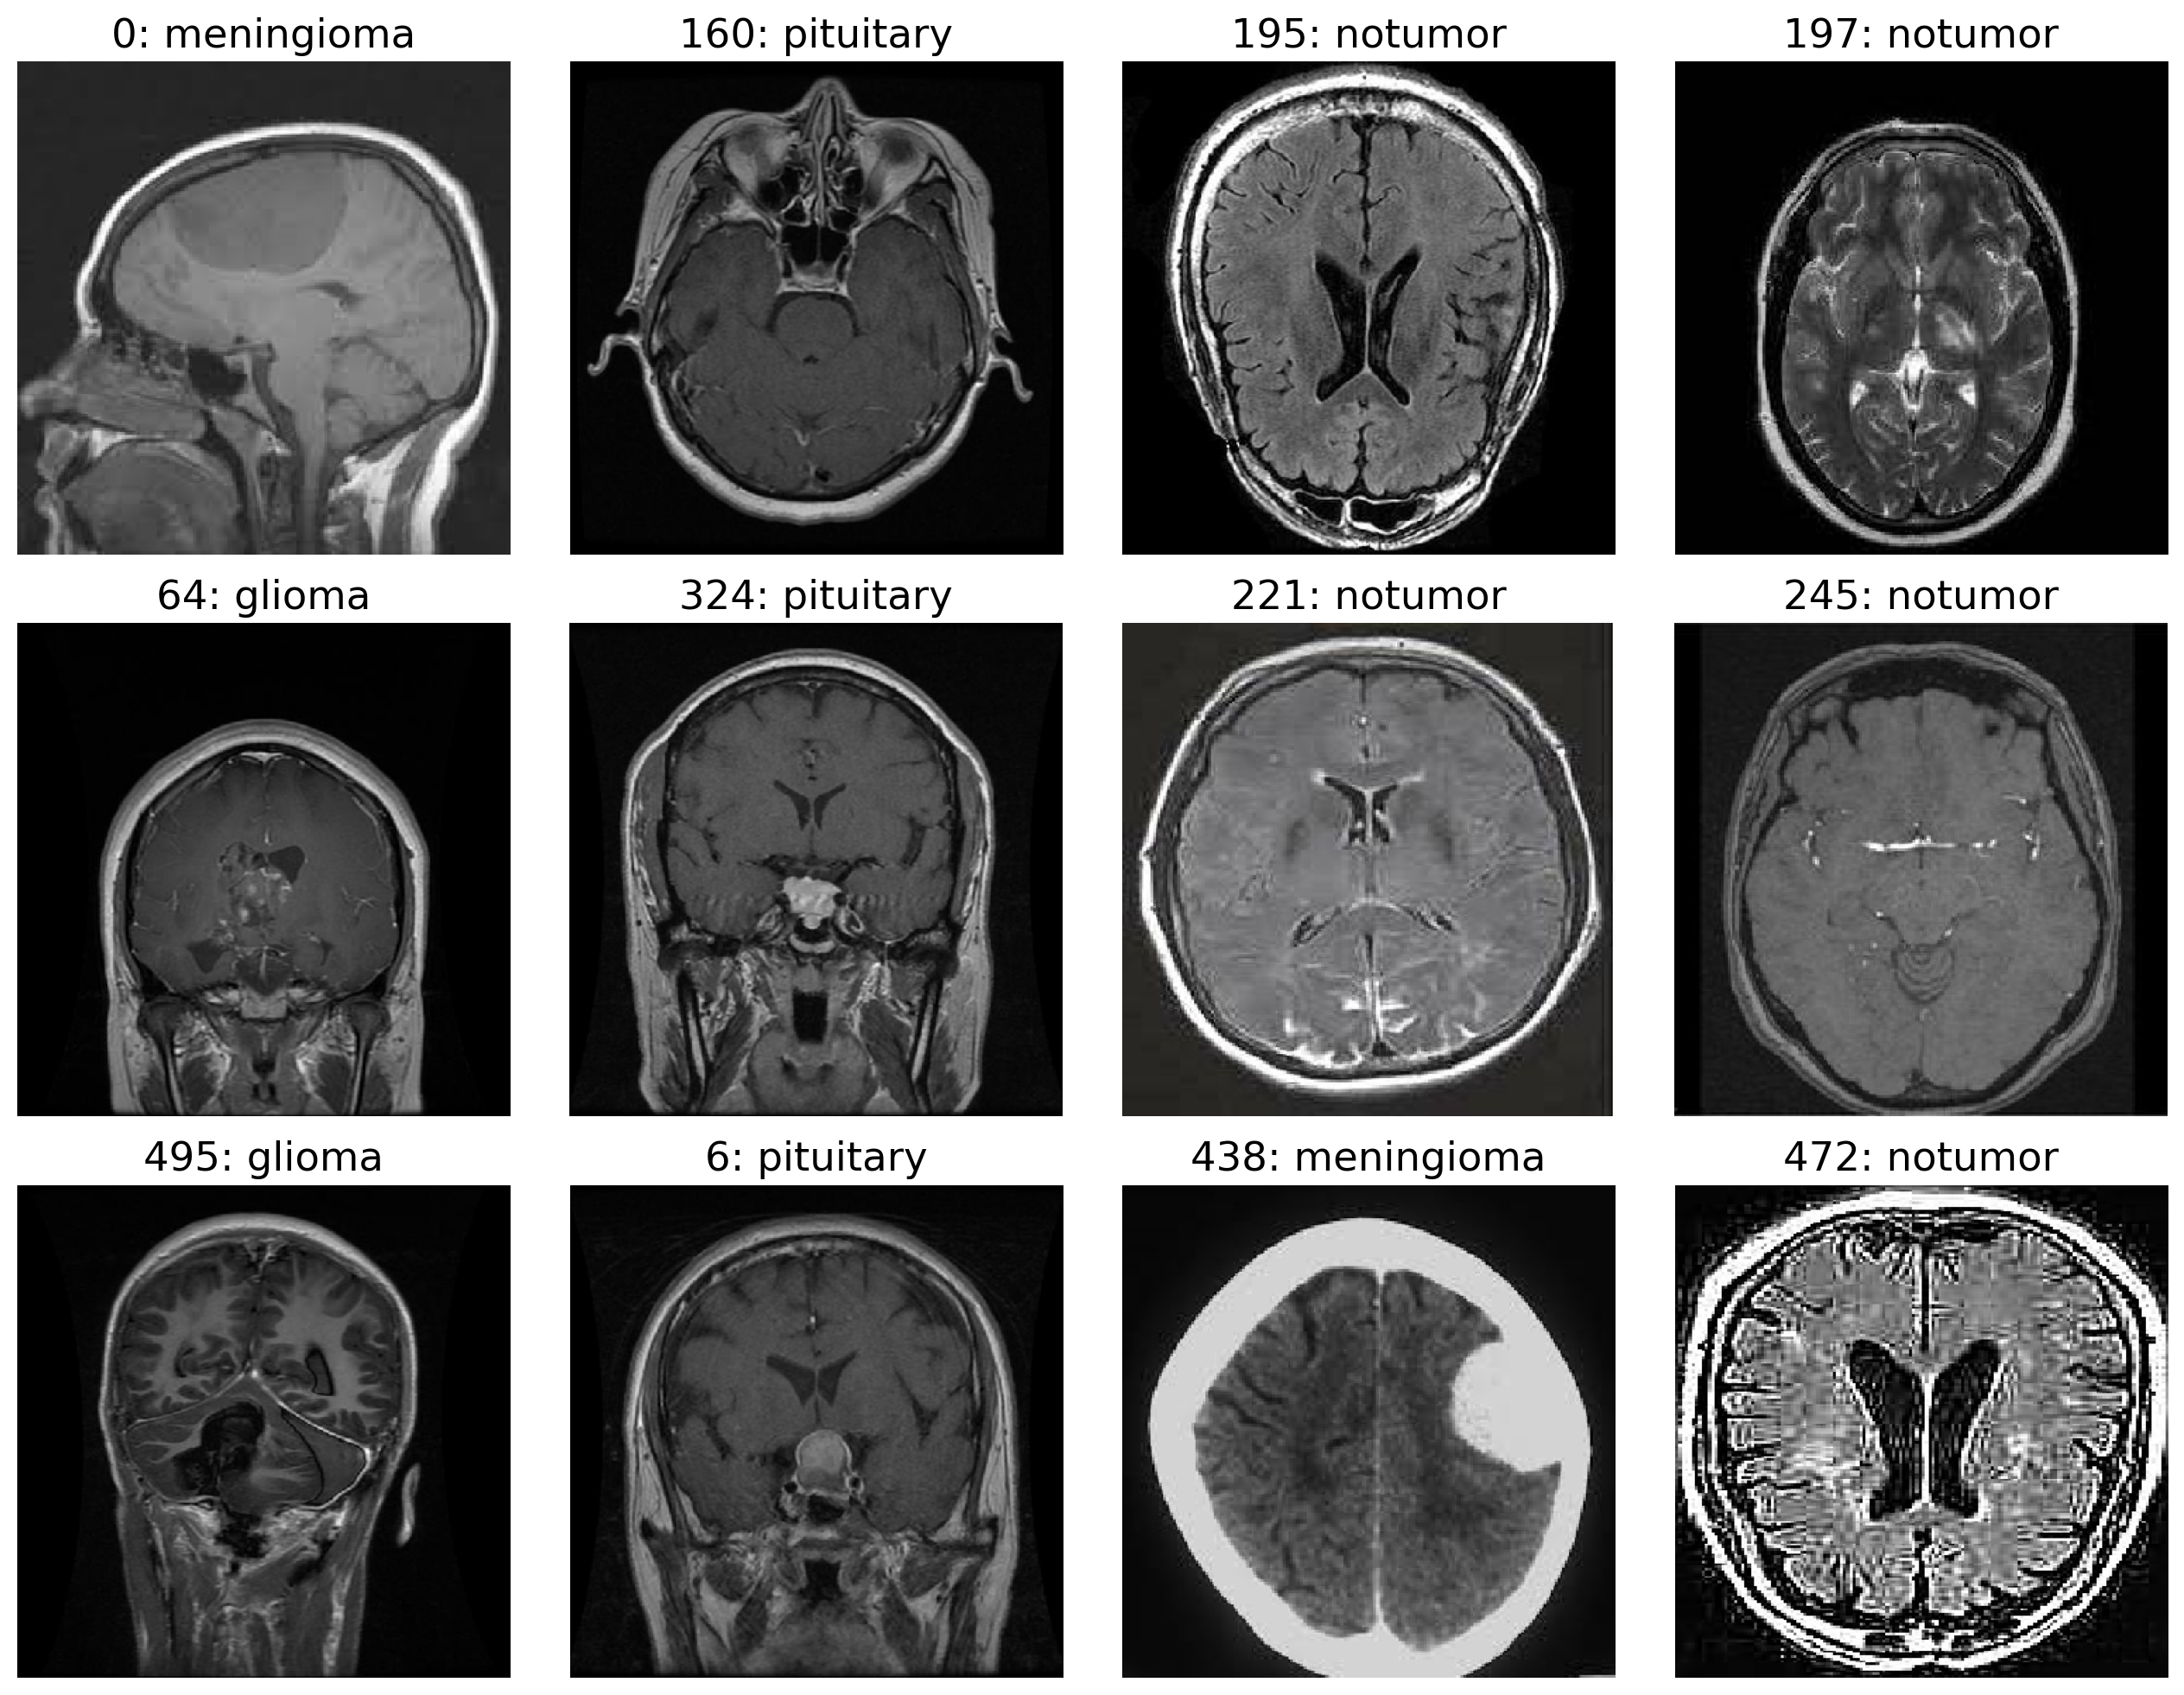

In [13]:
# Four different data classification images, from three different angles (images are independent)
show_images(train_paths,
            train_labels,
            index_list=[0, 160, 195, 197,
                        64, 324, 221, 245,
                        495, 6, 438, 472],
            im_size=350,
            figsize=(13,10),
            save=SAVE)

In [14]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")
# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [16]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [17]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    augmented_samples = train_generator.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()

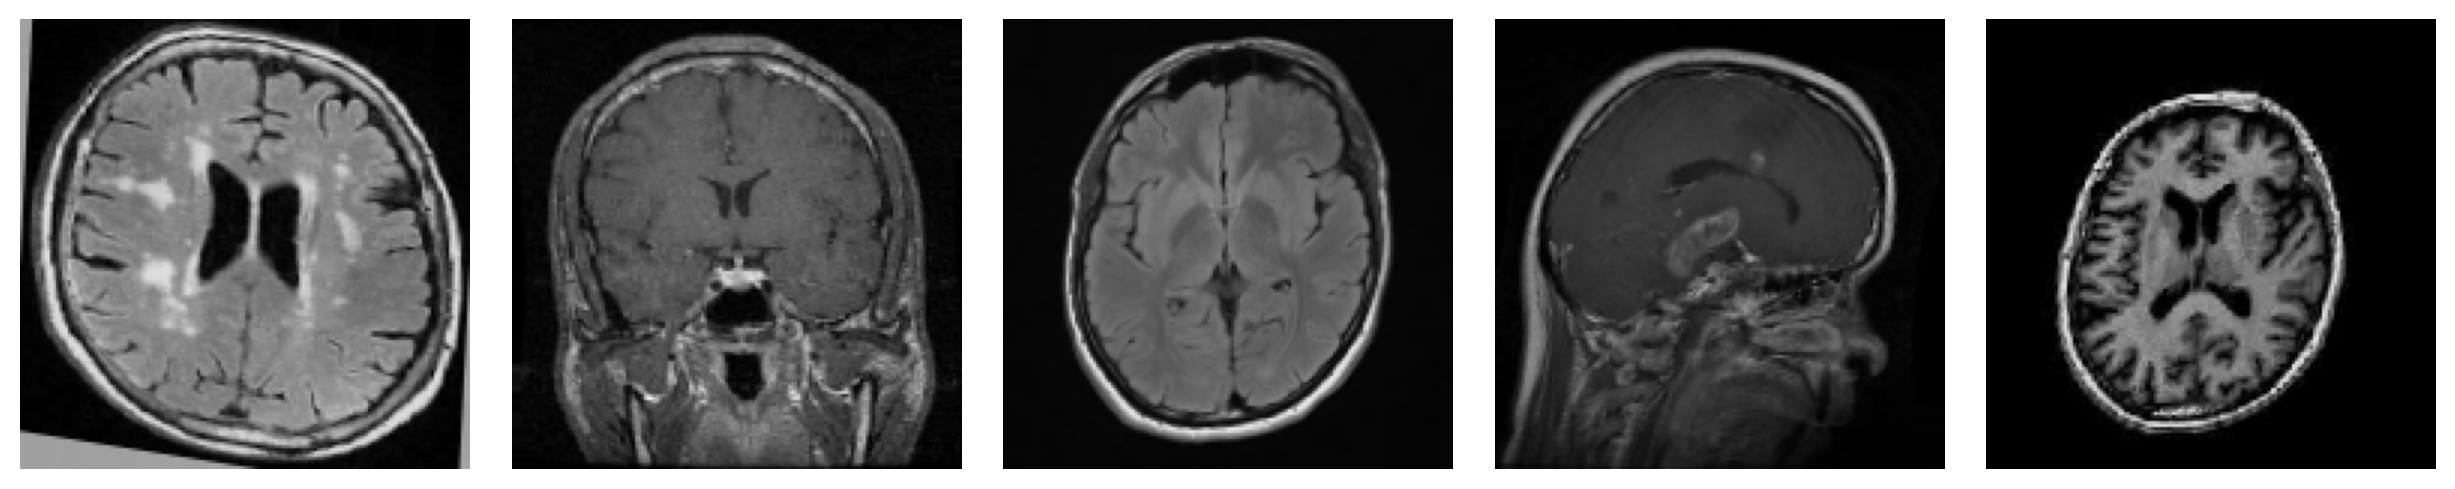

In [18]:
show_ImageDataGenerator(train_datagen, num_samples=5, figsize=(12.5, 8), save=SAVE)

In [19]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 35

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 35
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [20]:
# Output Images and Labels Visualization #

def plot_sample_predictions(model, test_generator, categories, test_dir, num_samples=9, figsize=(12, 8)):
    """
    Nice display of prediction samples to see CNN predictions
    for classification.
    """
    # Make predictions on the test dataset
    predictions = model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Randomly sample test images
    test_images = np.array(test_generator.filepaths)
    sample_indices = np.random.choice(len(test_images), size=num_samples, replace=False)
    sample_images = test_images[sample_indices]
    sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
    sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

    # Plot sample images with their predicted and true labels
    plt.figure(figsize=figsize)

    # Loop over samples
    for i, image_path in enumerate(sample_images):
        # Form subplot and plot
        plt.subplot(3, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.axis("off")

        # Set axis label color depending on correct prediction or not
        prediction_color = 'green' if sample_predictions[i] == sample_true_labels[i] else 'red'
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color=prediction_color)

    plt.tight_layout()
    plt.show()


#            Confusion matrix            #

def CM(CNN_model, test_generator, categories):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix
    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)

    return confusion_matrix_array



#             Metric Analysis            #

def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

model 1

In [21]:
# Define the model architecture
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Full connect layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(N_TYPES, activation="softmax"))

model_1.summary()
optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.0/993.0 kB 21.8 MB/s eta 0:00:00


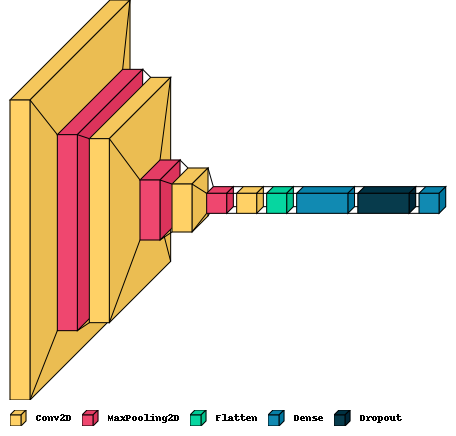

In [22]:
! pip install visualkeras
from visualkeras import layered_view

# Visualize the model
layered_view(model_1, legend=True, max_xy=300)

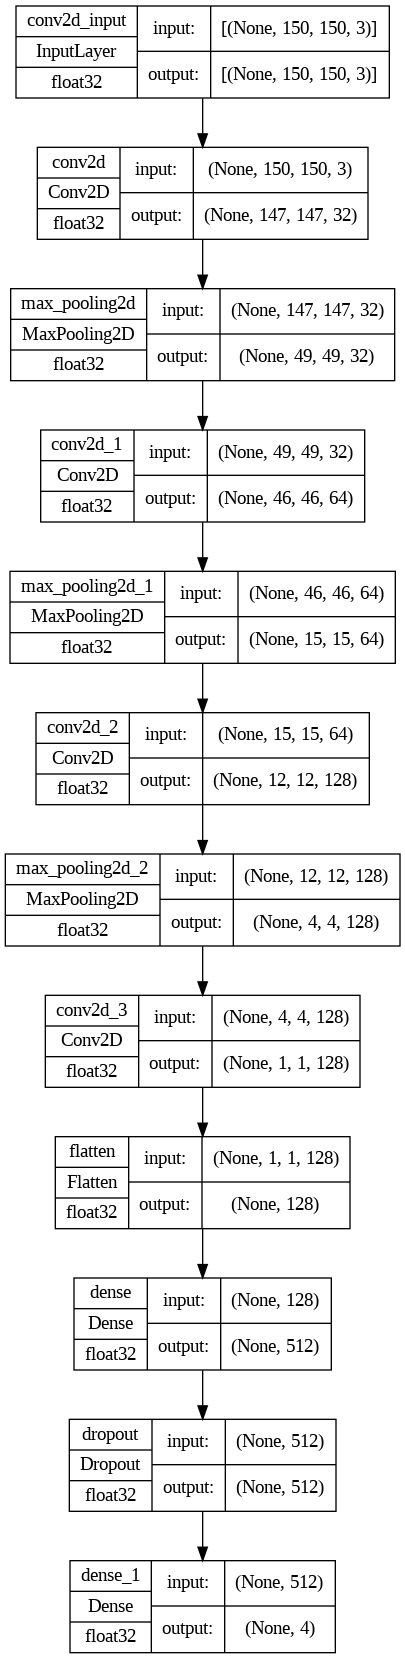

In [23]:
model_1_visual = models.Model(inputs=model_1.input, outputs=model_1.output)

# Save model architecture to a file
plot_model(model_1_visual, show_dtype=True, to_file='model_architecture.png', show_shapes=True)

# Display model architecture in the notebook

from IPython.display import Image
Image(retina=True, filename='model_architecture.png')

In [24]:
# Stop training if loss doesn't keep decreasing.
model_1_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_1_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history_1 = model_1.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps,
                        callbacks=[model_1_es, model_1_rlr])

Epoch 1/35
178/178 [==============================] - 52s 237ms/step - loss: 0.8424 - accuracy: 0.6250 - val_loss: 0.5924 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 2/35
178/178 [==============================] - 43s 240ms/step - loss: 0.4975 - accuracy: 0.8035 - val_loss: 0.6195 - val_accuracy: 0.7484 - lr: 0.0010
Epoch 3/35
178/178 [==============================] - 42s 238ms/step - loss: 0.4111 - accuracy: 0.8301 - val_loss: 0.4170 - val_accuracy: 0.8359 - lr: 0.0010
Epoch 4/35
178/178 [==============================] - 42s 236ms/step - loss: 0.3223 - accuracy: 0.8773 - val_loss: 0.4230 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 5/35
178/178 [==============================] - 43s 243ms/step - loss: 0.2512 - accuracy: 0.9053 - val_loss: 0.3398 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 6/35
178/178 [==============================] - 42s 237ms/step - loss: 0.2130 - accuracy: 0.9215 - val_loss: 0.4493 - val_accuracy: 0.8461 - lr: 0.0010
Epoch 7/35
178/178 [==============================] 

In [25]:
loss, accuracy = model_1.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 [==============================] - 2s 61ms/step - loss: 0.0736 - accuracy: 0.9859
Test Loss: 0.07364
Test Accuracy: 0.98594


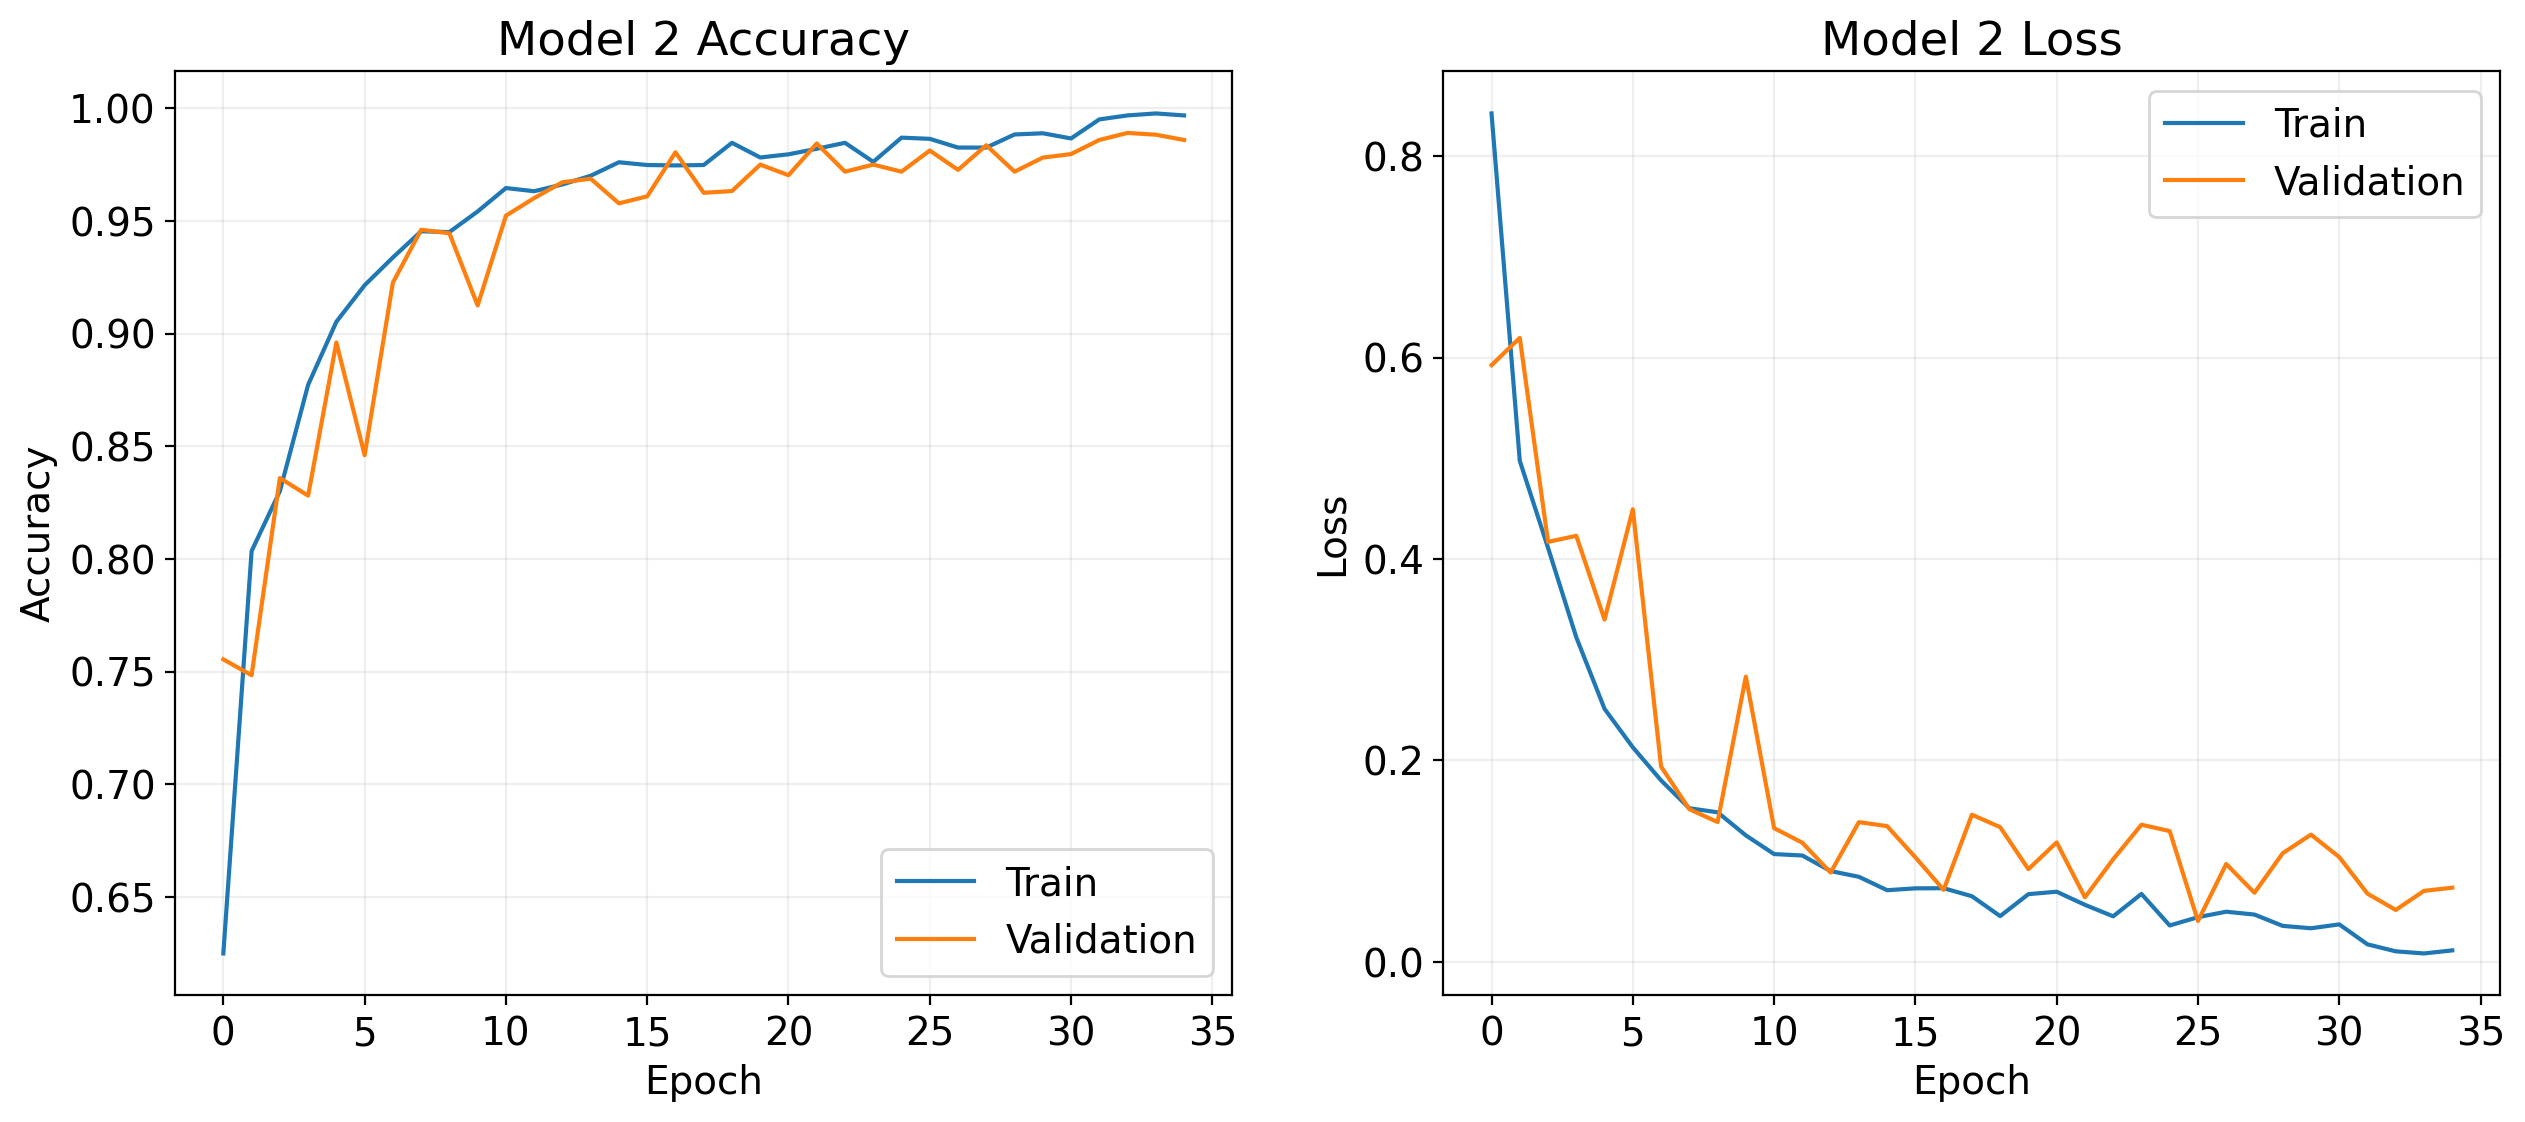

In [26]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_1.history['accuracy'])
ax[0].plot(history_1.history['val_accuracy'])
ax[0].set_title('Model 2 Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_1.history['loss'])
ax[1].plot(history_1.history['val_loss'])
ax[1].set_title('Model 2 Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)

plt.show()

41/41 [==============================] - 3s 71ms/step


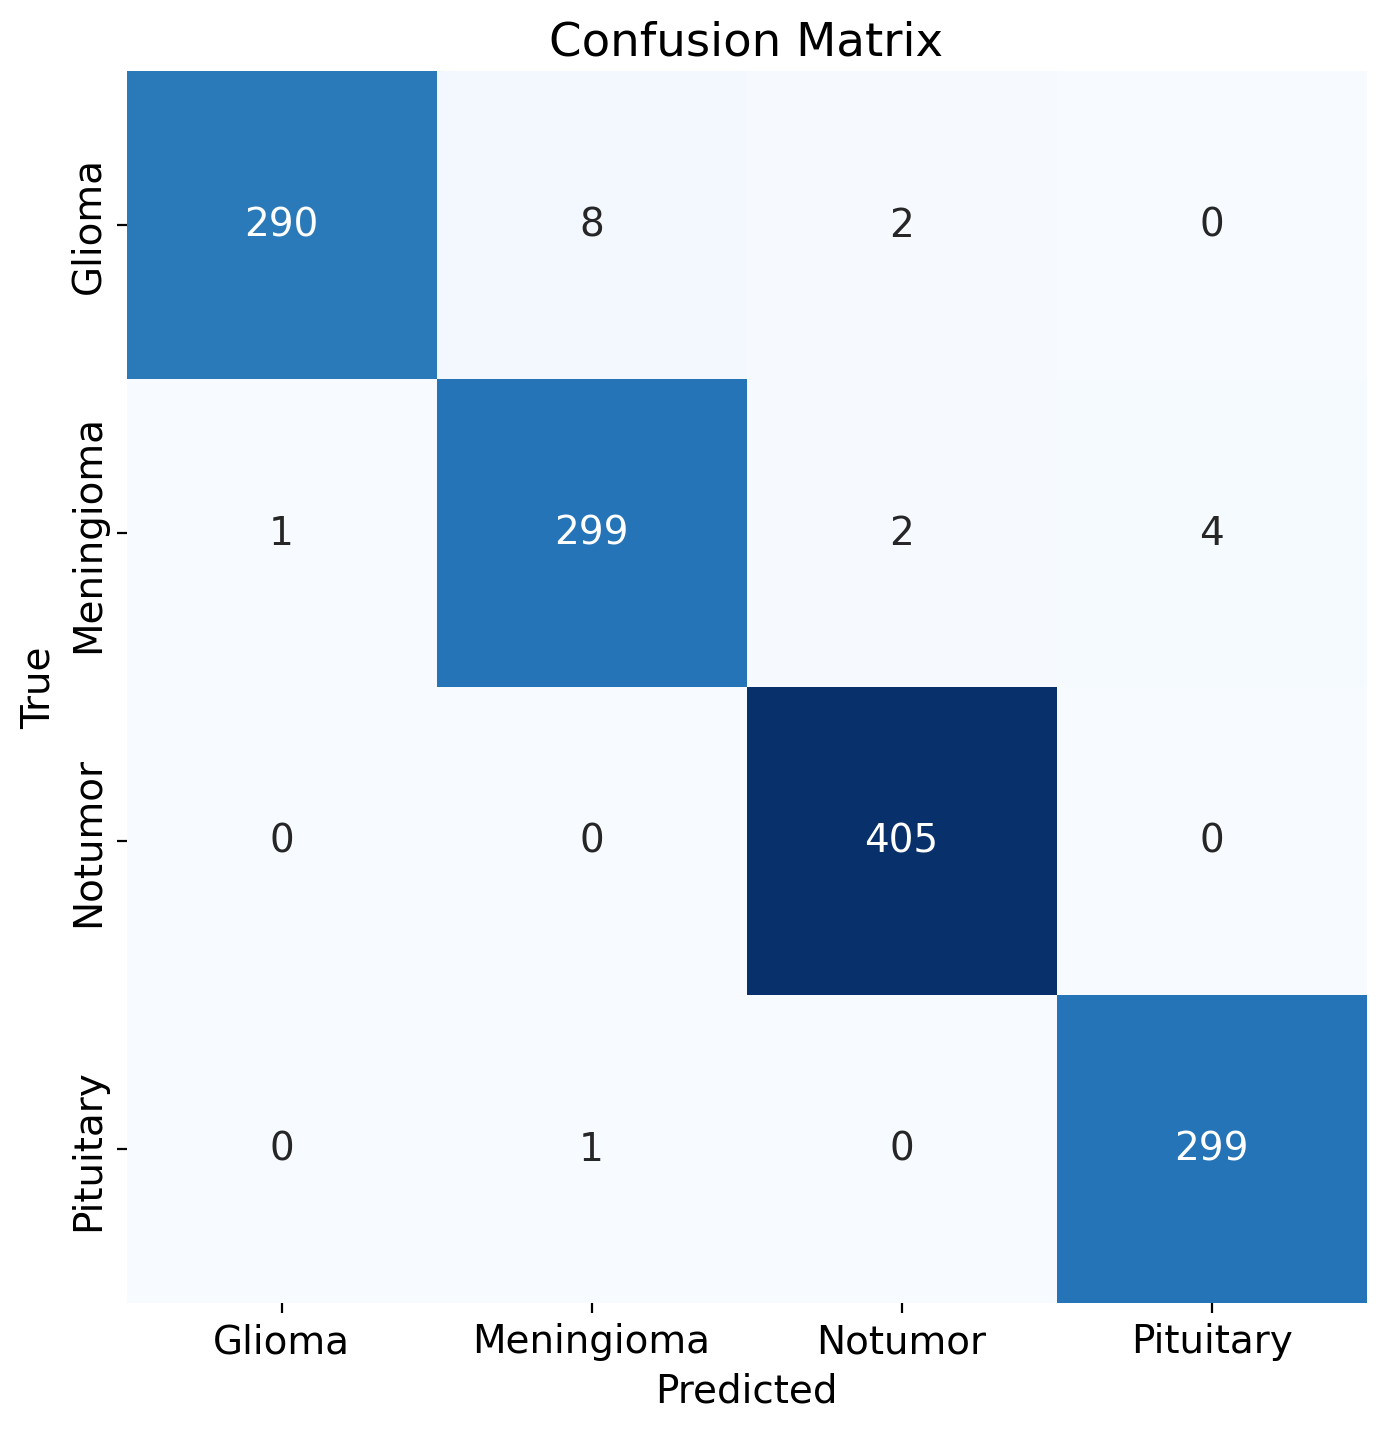

In [27]:
# Plotting confusion matrix
confusion_matrix_1 = CM(CNN_model=model_1, test_generator=test_generator, categories=CLASS_TYPES)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [56]:
calculate_metrics(confusion_matrix_1, categories=CLASS_TYPES)

Class: Pituitary
Precision: 0.997
Recall: 0.967
F1-Score: 0.981

Class: Notumor
Precision: 0.971
Recall: 0.977
F1-Score: 0.974

Class: Meningioma
Precision: 0.990
Recall: 1.000
F1-Score: 0.995

Class: Glioma
Precision: 0.987
Recall: 0.997
F1-Score: 0.992


Accuracy: 0.986
